In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Complete file name of the Lattice Microbes Trajectory
# filename = '/home/zane/Models/mincell/mc4d/Data/division_6000_1/MinCell.lm'
# wd = '/Data1/zane/Models/mincell/Dec23_28_Jan2/'
wd = '/Data1/zane/Models/mincell/Jan31/'

repN = 8

fn = 'MC_'
fn = 'MinCell_'
ext = '.lm'
reps = []
for i in range(1,repN+1):
    traj = h5py.File(wd+fn+str(i)+ext)
    if float(traj['Simulations']['0000001']['LatticeTimes'][-1])!=6000:
        print(i, traj['Simulations']['0000001']['LatticeTimes'][-1])
    reps.append(i)
reps

[1, 2, 3, 4, 5, 6, 7, 8]

In [3]:
sNbin = traj['Parameters']['SpeciesNames']
sN = []
for n in sNbin:
    sN.append(n[0].decode("utf-8"))

def getIdx(name):
    return int(sN.index(name)+1)

In [4]:
siteNames = traj['Parameters'].attrs['siteTypeNames'].decode("utf-8").split(',')

def getSiteIdx(name):
    return int(siteNames.index(name))

print(getSiteIdx('outer_cytoplasm'))
siteNames

2


['extracellular',
 'cytoplasm',
 'outer_cytoplasm',
 'ribosomes',
 'ribo_centers',
 'DNA',
 'membrane']

In [5]:
def getcoords(spec, time=None):

    coords = []

    for rep in reps:

        traj = h5py.File(wd+fn+str(rep)+ext)

        if time is None:
            t = int(traj['Simulations']['0000001']['LatticeTimes'][-1])
        else:
            t = time
    
        pL = np.array(traj['Simulations']['0000001']['Lattice']['000000{}'.format(t)])

        scoords = np.argwhere(pL==getIdx(spec))

        scoords = scoords.T[0:3].T

        coords.append(scoords)

        # print(coords)

    return coords

In [6]:
def getcoordsMult(specList, time=None):

    coords = []

    for rep in reps:

        traj = h5py.File(wd+fn+str(rep)+ext)

        if time is None:
            t = int(traj['Simulations']['0000001']['LatticeTimes'][-1])
        else:
            t = time
    
        pL = np.array(traj['Simulations']['0000001']['Lattice']['000000{}'.format(t)])

        scoords = None

        for spec in specList:

            if scoords is None:

                scoords = np.argwhere(pL==getIdx(spec))

            else:

                sc = np.argwhere(pL==getIdx(spec))

                scoords = np.concatenate((scoords, sc), axis=0)

        scoords = scoords.T[0:3].T

        coords.append(scoords)

        # print(coords)

    return coords

In [7]:
def getSiteCoords(site, time=None):

    coords = []

    for rep in reps:

        traj = h5py.File(wd+fn+str(rep)+ext)

        if time is None:
            t = int(traj['Simulations']['0000001']['LatticeTimes'][-1])
        else:
            t = time
    
        pL = np.array(traj['Simulations']['0000001']['Sites']['000000{}'.format(t)])

        scoords = np.argwhere(pL==getSiteIdx(site))

        scoords = scoords.T[0:3].T

        coords.append(scoords)

        # print(coords)

    return coords

In [8]:
def getDividedDist(data=None, spec=None, specList=None):

    counts_per_cell = []

    for i in range(len(reps)):
    
        scoords = data[i]
    
        cell1 = 0
        cell2 = 0
    
        for coord in scoords:
    
            if coord[0]<64:
    
                cell1+=1
    
            else:
    
                cell2+=1
    
        counts_per_cell.append(cell1)
        counts_per_cell.append(cell2)

    return counts_per_cell

In [9]:
def getPartitionedParticles(data):

    countsPerCell = {
        'Left':[],
        'Right':[]
    }

    for i in range(len(reps)):
    
        scoords = data[i]
    
        cell1 = 0
        cell2 = 0
    
        for coord in scoords:
    
            if coord[0]<64:
    
                cell1+=1
    
            else:
    
                cell2+=1
    
        countsPerCell['Left'].append(cell1)
        countsPerCell['Right'].append(cell2)

    return countsPerCell

In [10]:
def plotPartitioning(data, specID=None):

    if specID is None:
        sID = ''
    else:
        sID = specID + ' '

    x = np.arange(len(reps))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({"font.family": 'sans-serif'})

    plt.rcParams['figure.dpi'] = 300
    
    fig, ax = plt.subplots(layout='constrained', figsize=(8,6))

    max_count = 0
    
    for side, count in data.items():
        # offset = width * multiplier
        if side == 'Left':
            offset = -width
            color = 'b'
        elif side == 'Right':
            offset = width
            color = 'r'
        rects = ax.bar(x + offset, count, width, label=side+' Cell', color=color)
        for c in count:
            if c>max_count:
                max_count = c

        # ax.bar_label(rects, padding=3)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Particle Count')
    ax.set_xlabel('Replicate Cell')
    ax.set_title('Paritioning to Daughter Cells After Division: ' + sID)
    ax.set_ylim([0,max_count*1.25])
    ax.set_xticks(x, reps)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0, 700)
    
    plt.tight_layout()
    plt.savefig('./partition_{}.png'.format(specID))

In [11]:
def plotDivDist(data, specID = None):

    if specID is None:
        sID = ''
    else:
        sID = specID + ' '

    fig = plt.figure(figsize=(8,6))

    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({"font.family": 'sans-serif'})

    plt.rcParams['figure.dpi'] = 300

    plt.hist(data, color='yellow', edgecolor='k', linewidth=1.2)
    plt.axvline(np.average(data), color='red', linewidth=3)
    plt.legend(['Average: '+str(int(np.average(dist)))])
    plt.xlabel('Particle Count')
    plt.ylabel('Cells')
    plt.title('Molecules per Cell After Division: ' + sID)
    plt.tight_layout()
    plt.savefig('./dist_{}.png'.format(specID))

/tmp/ipykernel_2060447/592334880.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


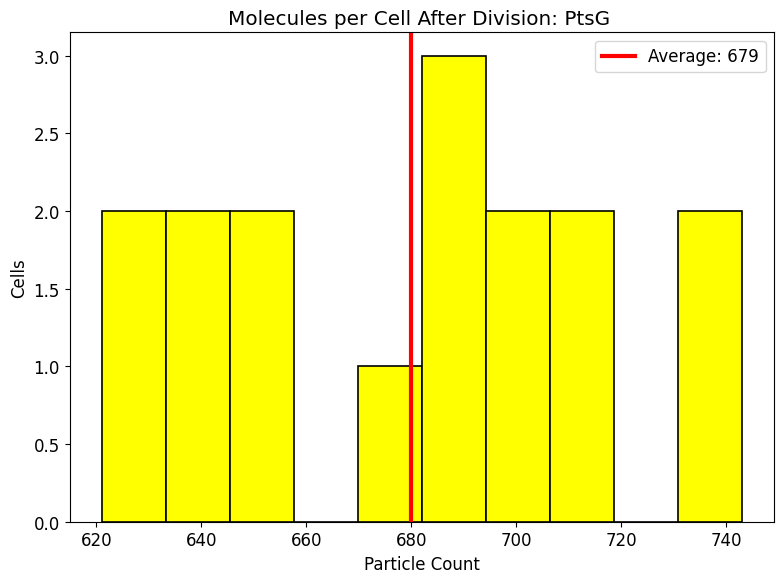

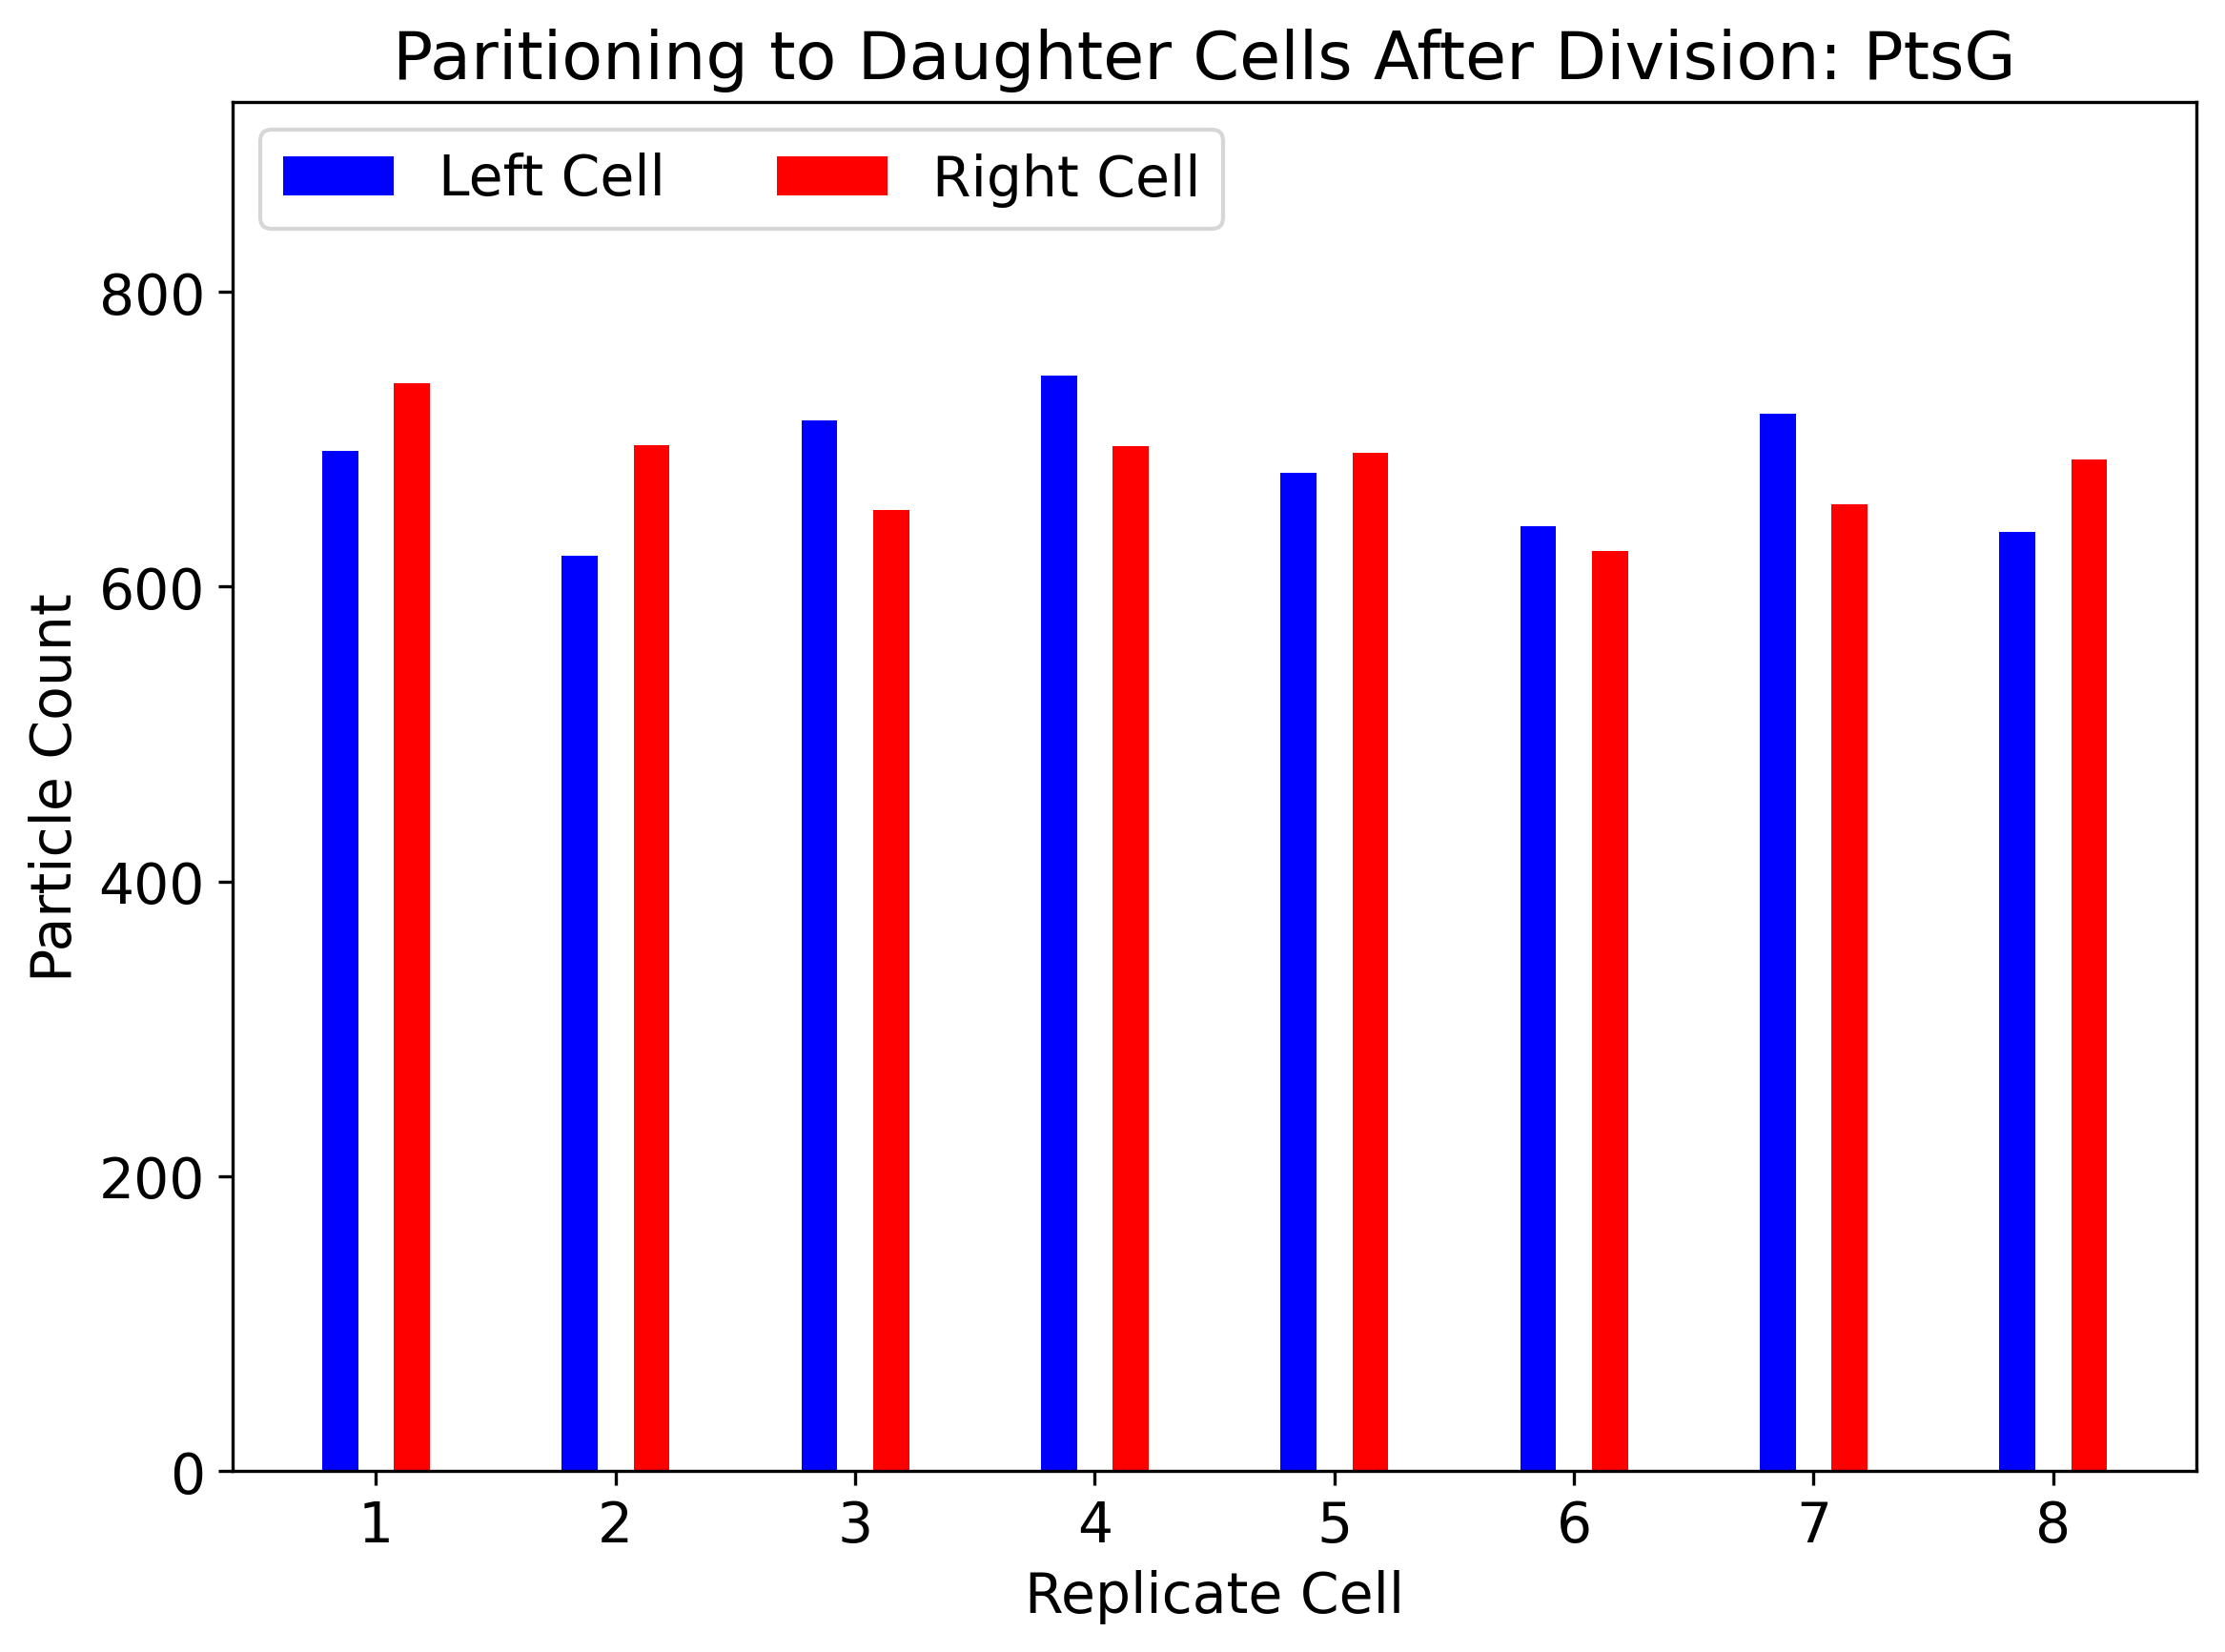

In [12]:
specID = 'P_0779'

specCoords = getcoords(specID)

dist = getDividedDist(specCoords)
plotDivDist(dist, 'PtsG')

partition = getPartitionedParticles(specCoords)
plotPartitioning(partition, 'PtsG')

/tmp/ipykernel_2060447/592334880.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


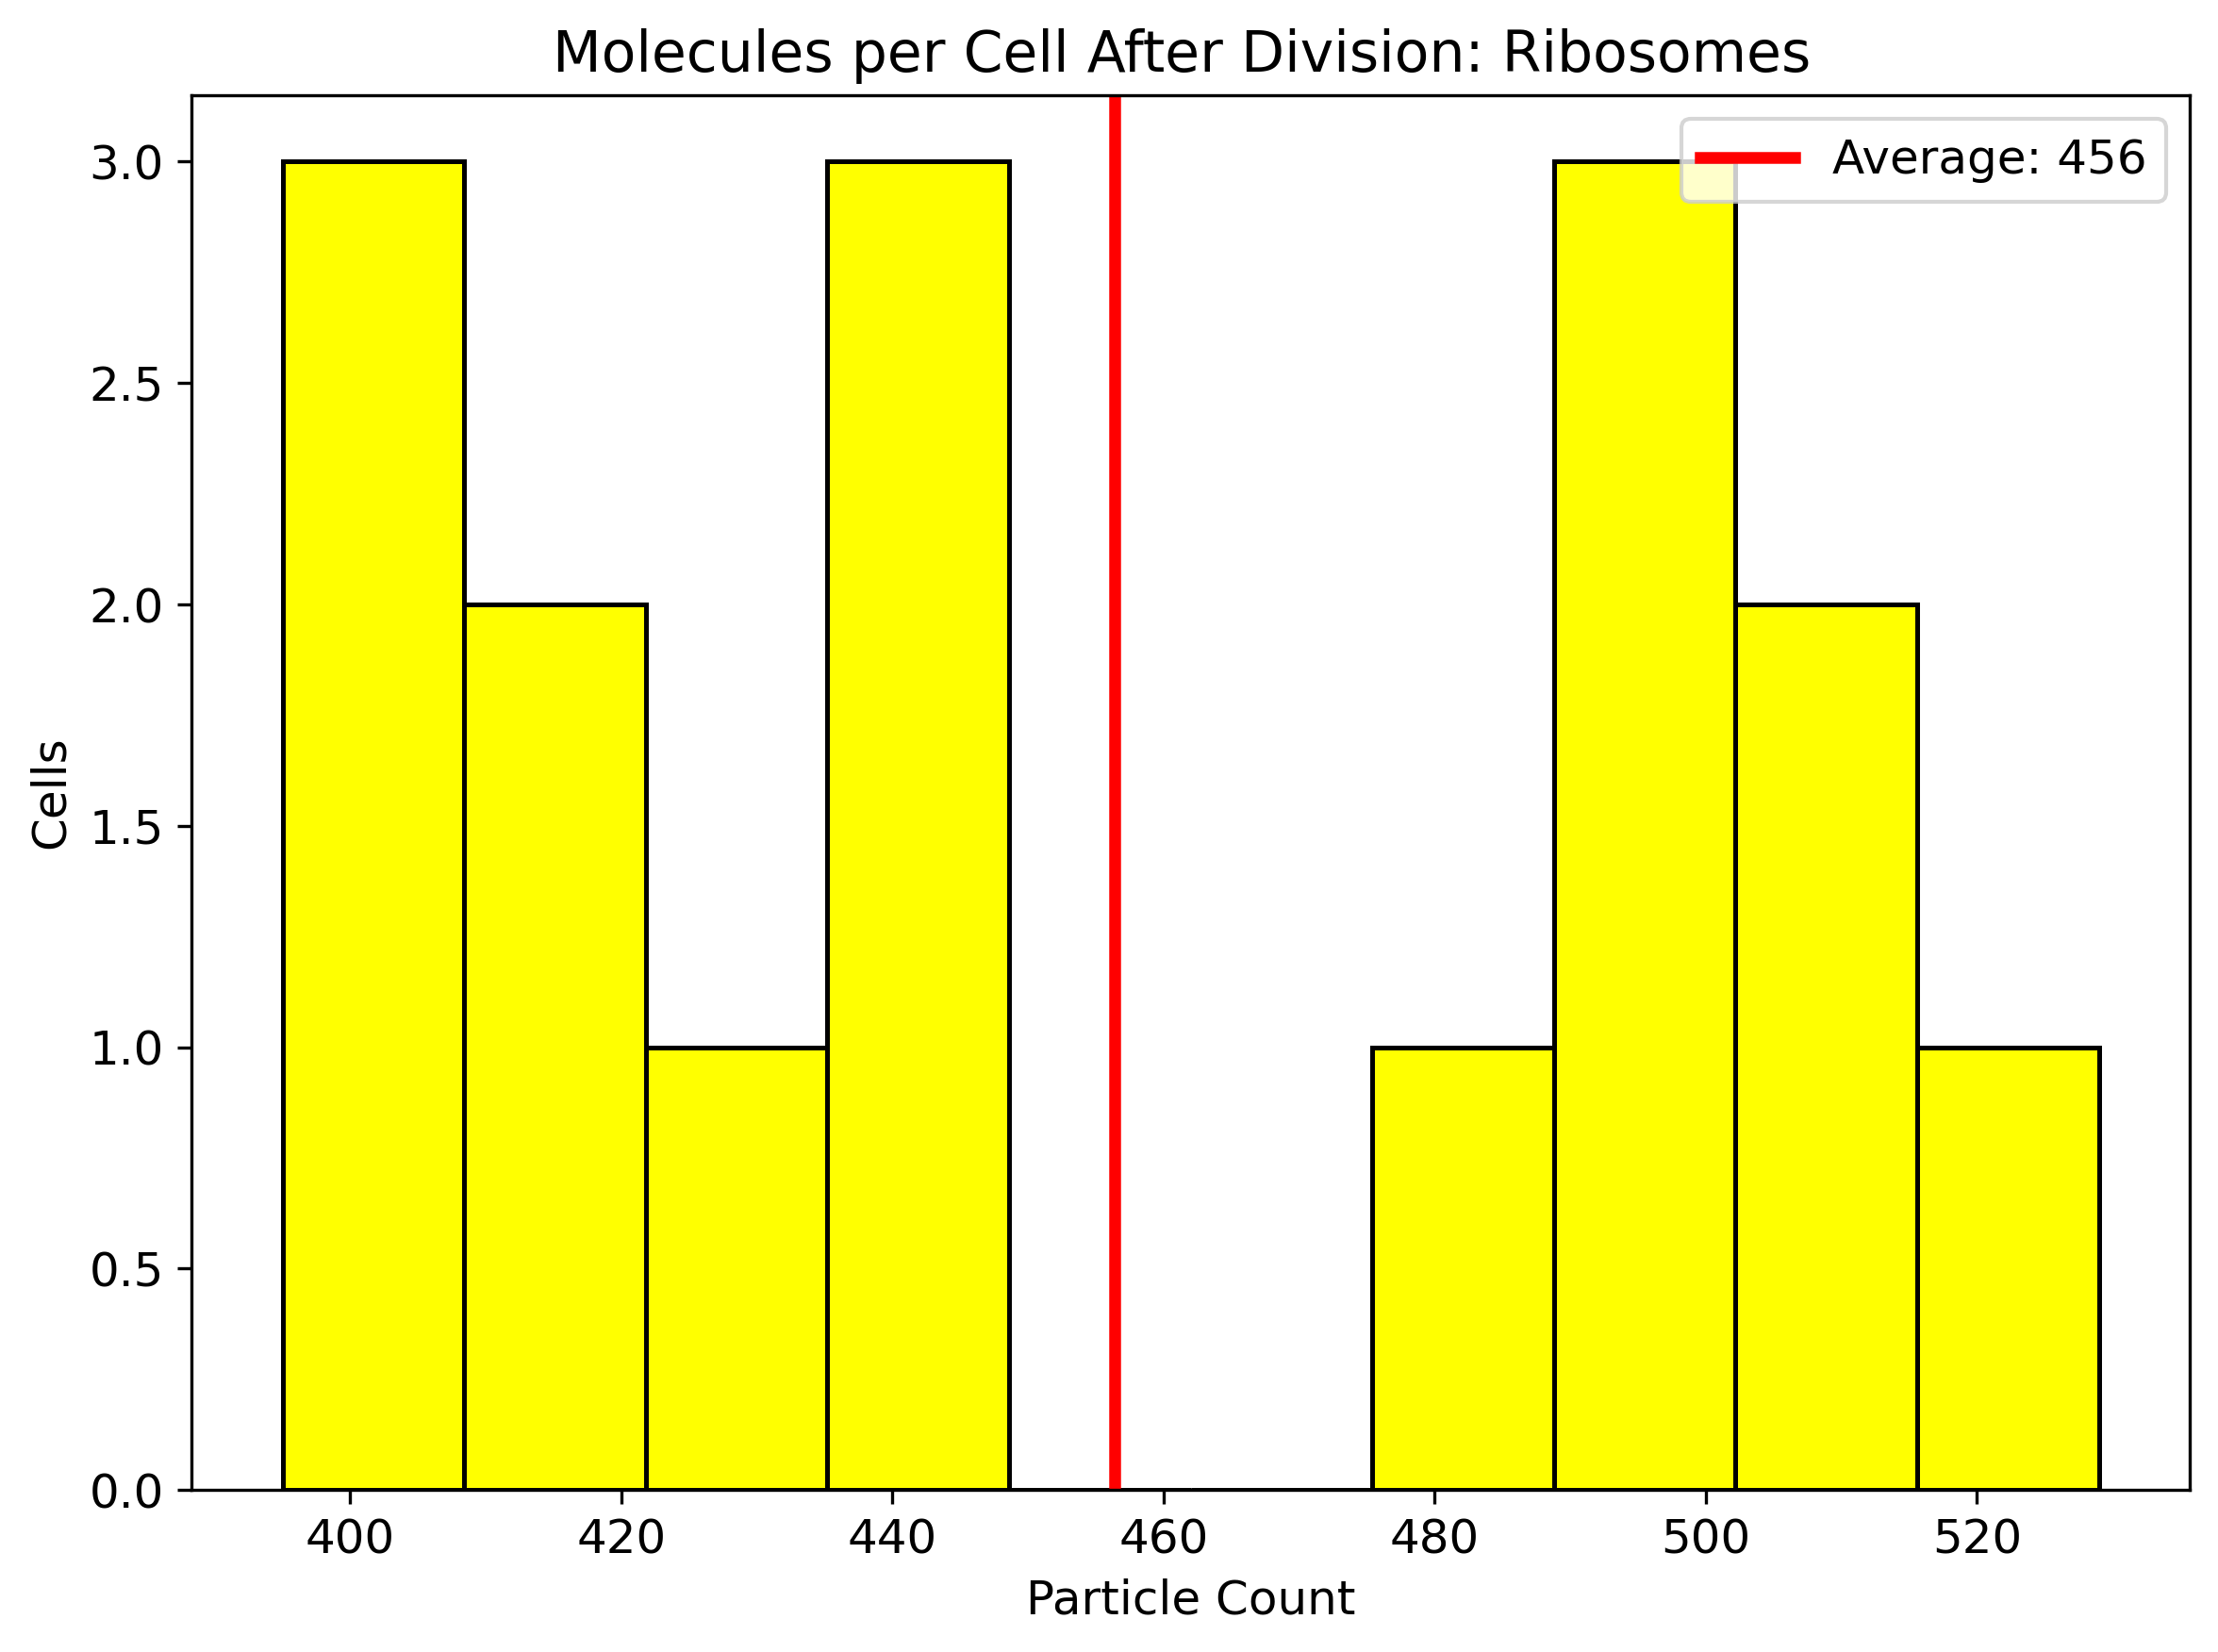

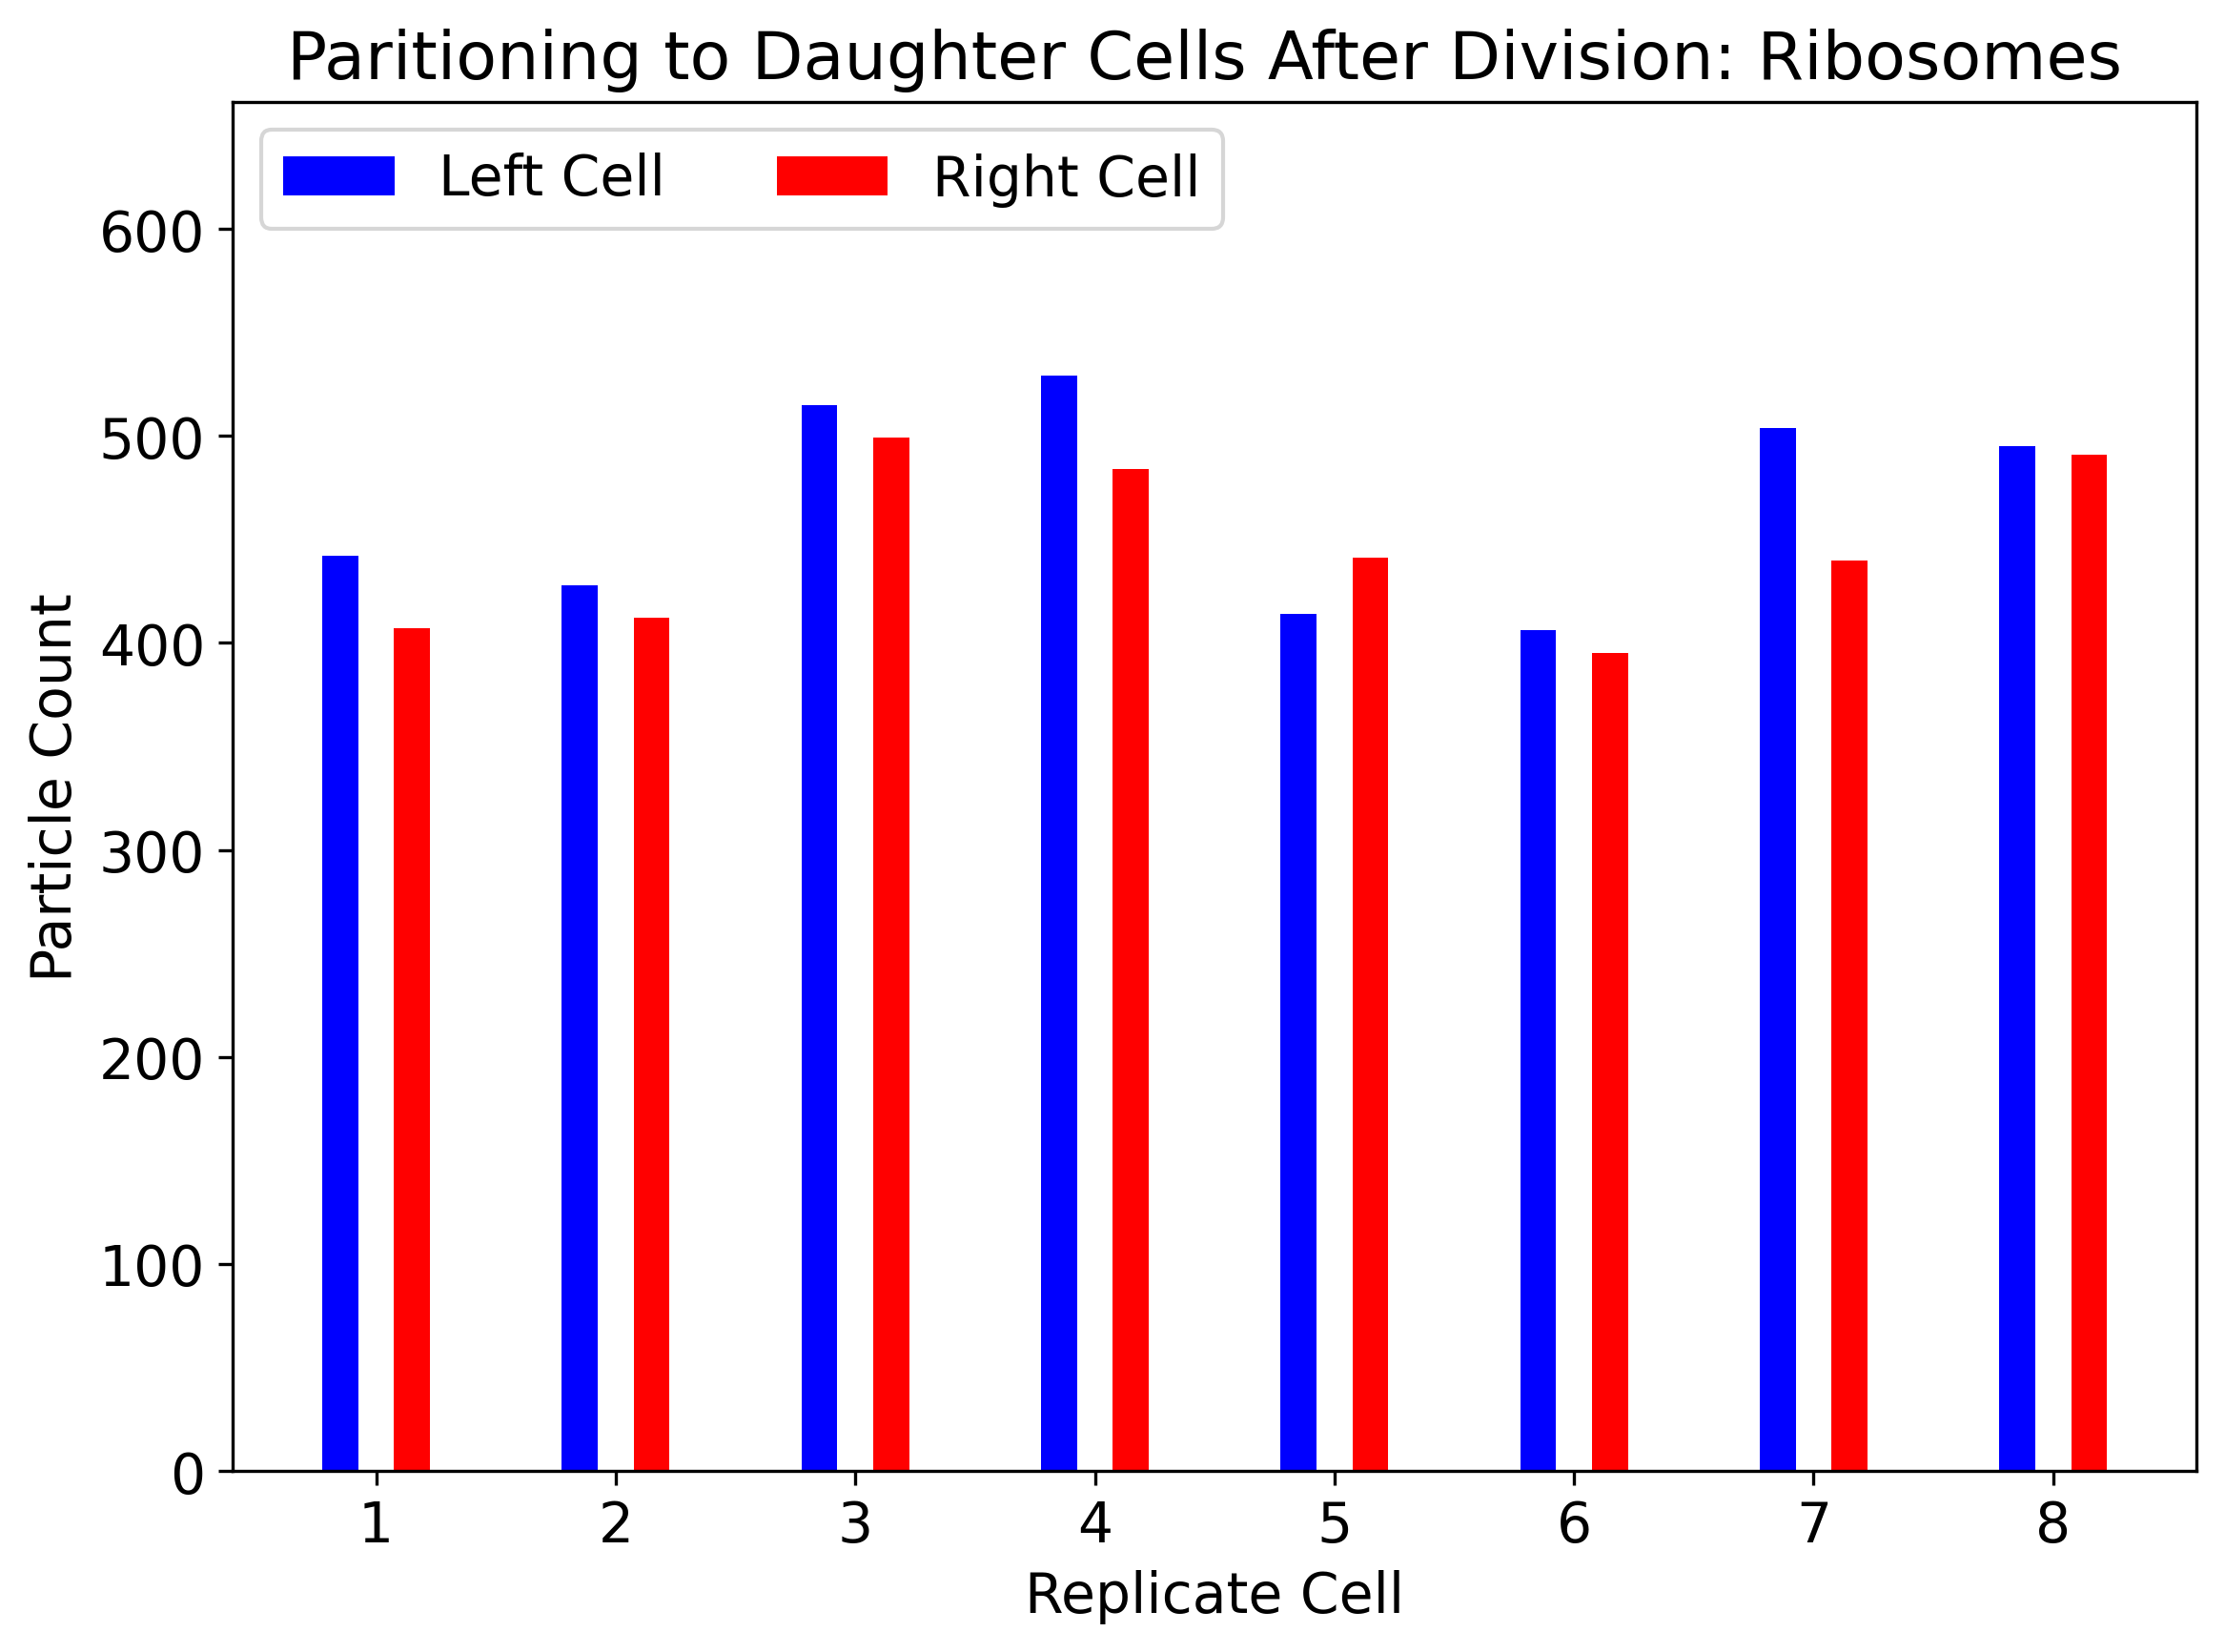

In [13]:
specID = ['ribosomeP']

for pID in sN:
    if pID.startswith('RB_'):
        specID.append(pID)

specCoords = getcoordsMult(specID)

dist = getDividedDist(specCoords)
plotDivDist(dist, 'Ribosomes')

partition = getPartitionedParticles(specCoords)
plotPartitioning(partition, 'Ribosomes')

/tmp/ipykernel_2060447/592334880.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


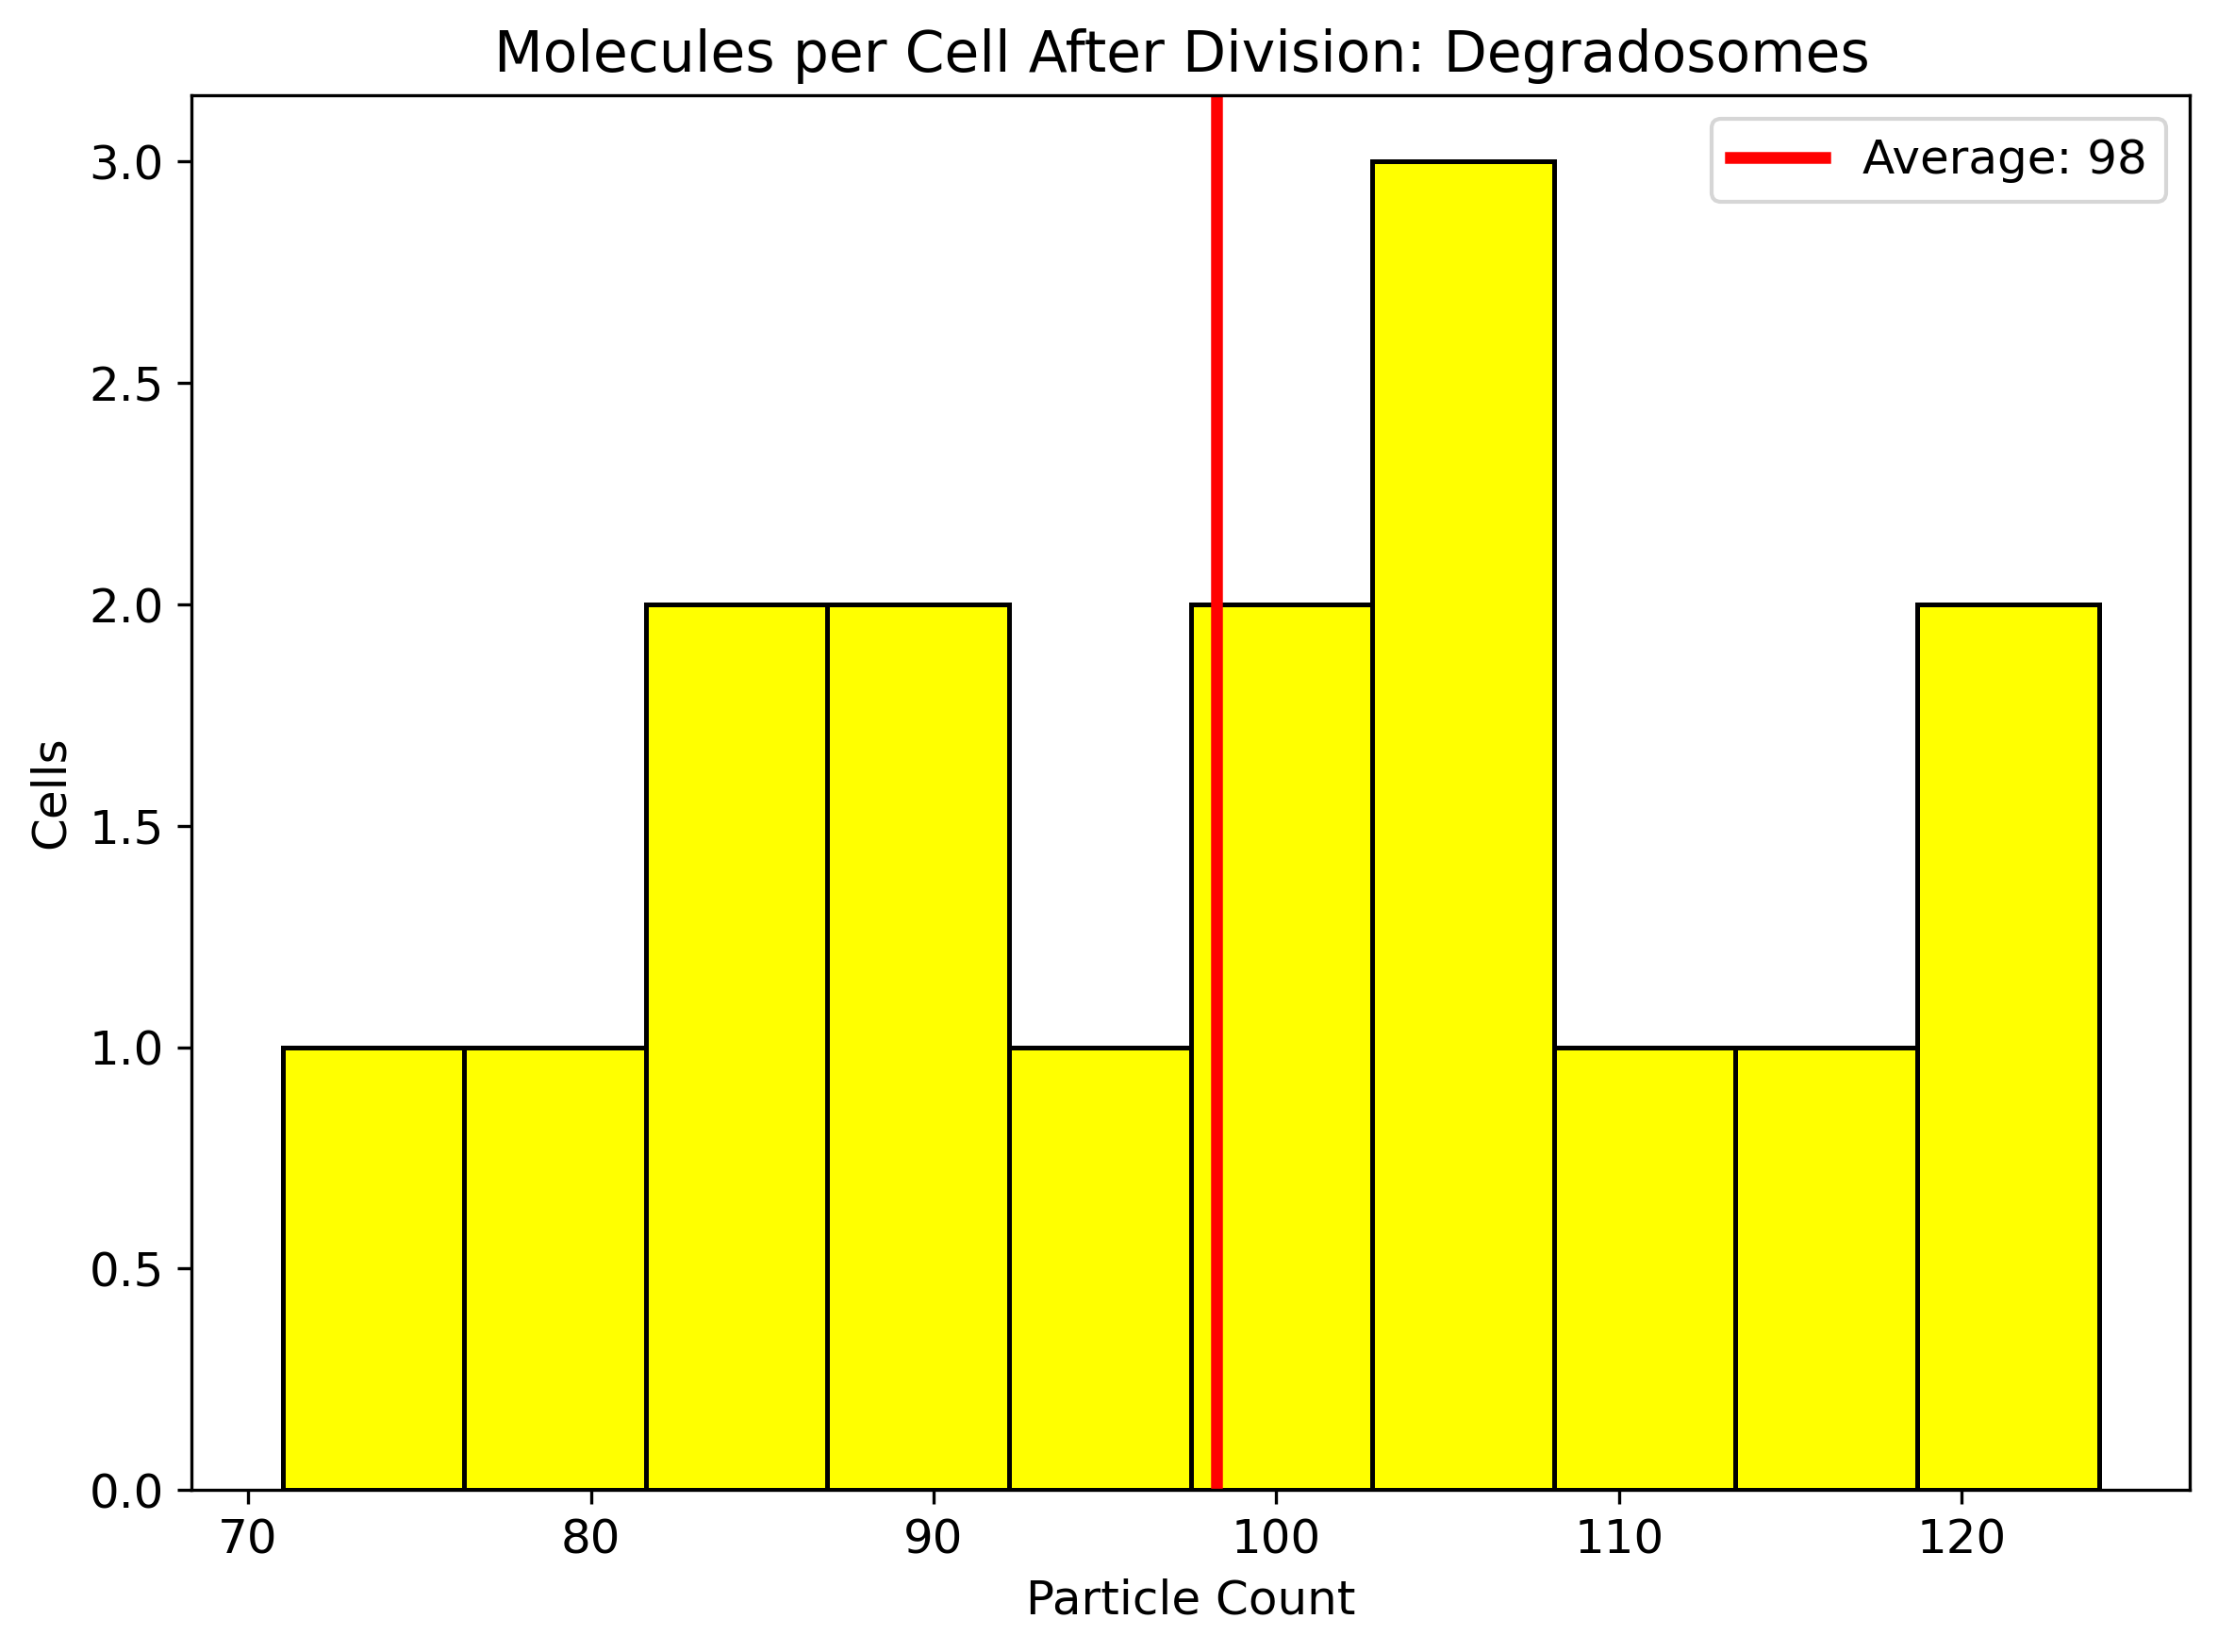

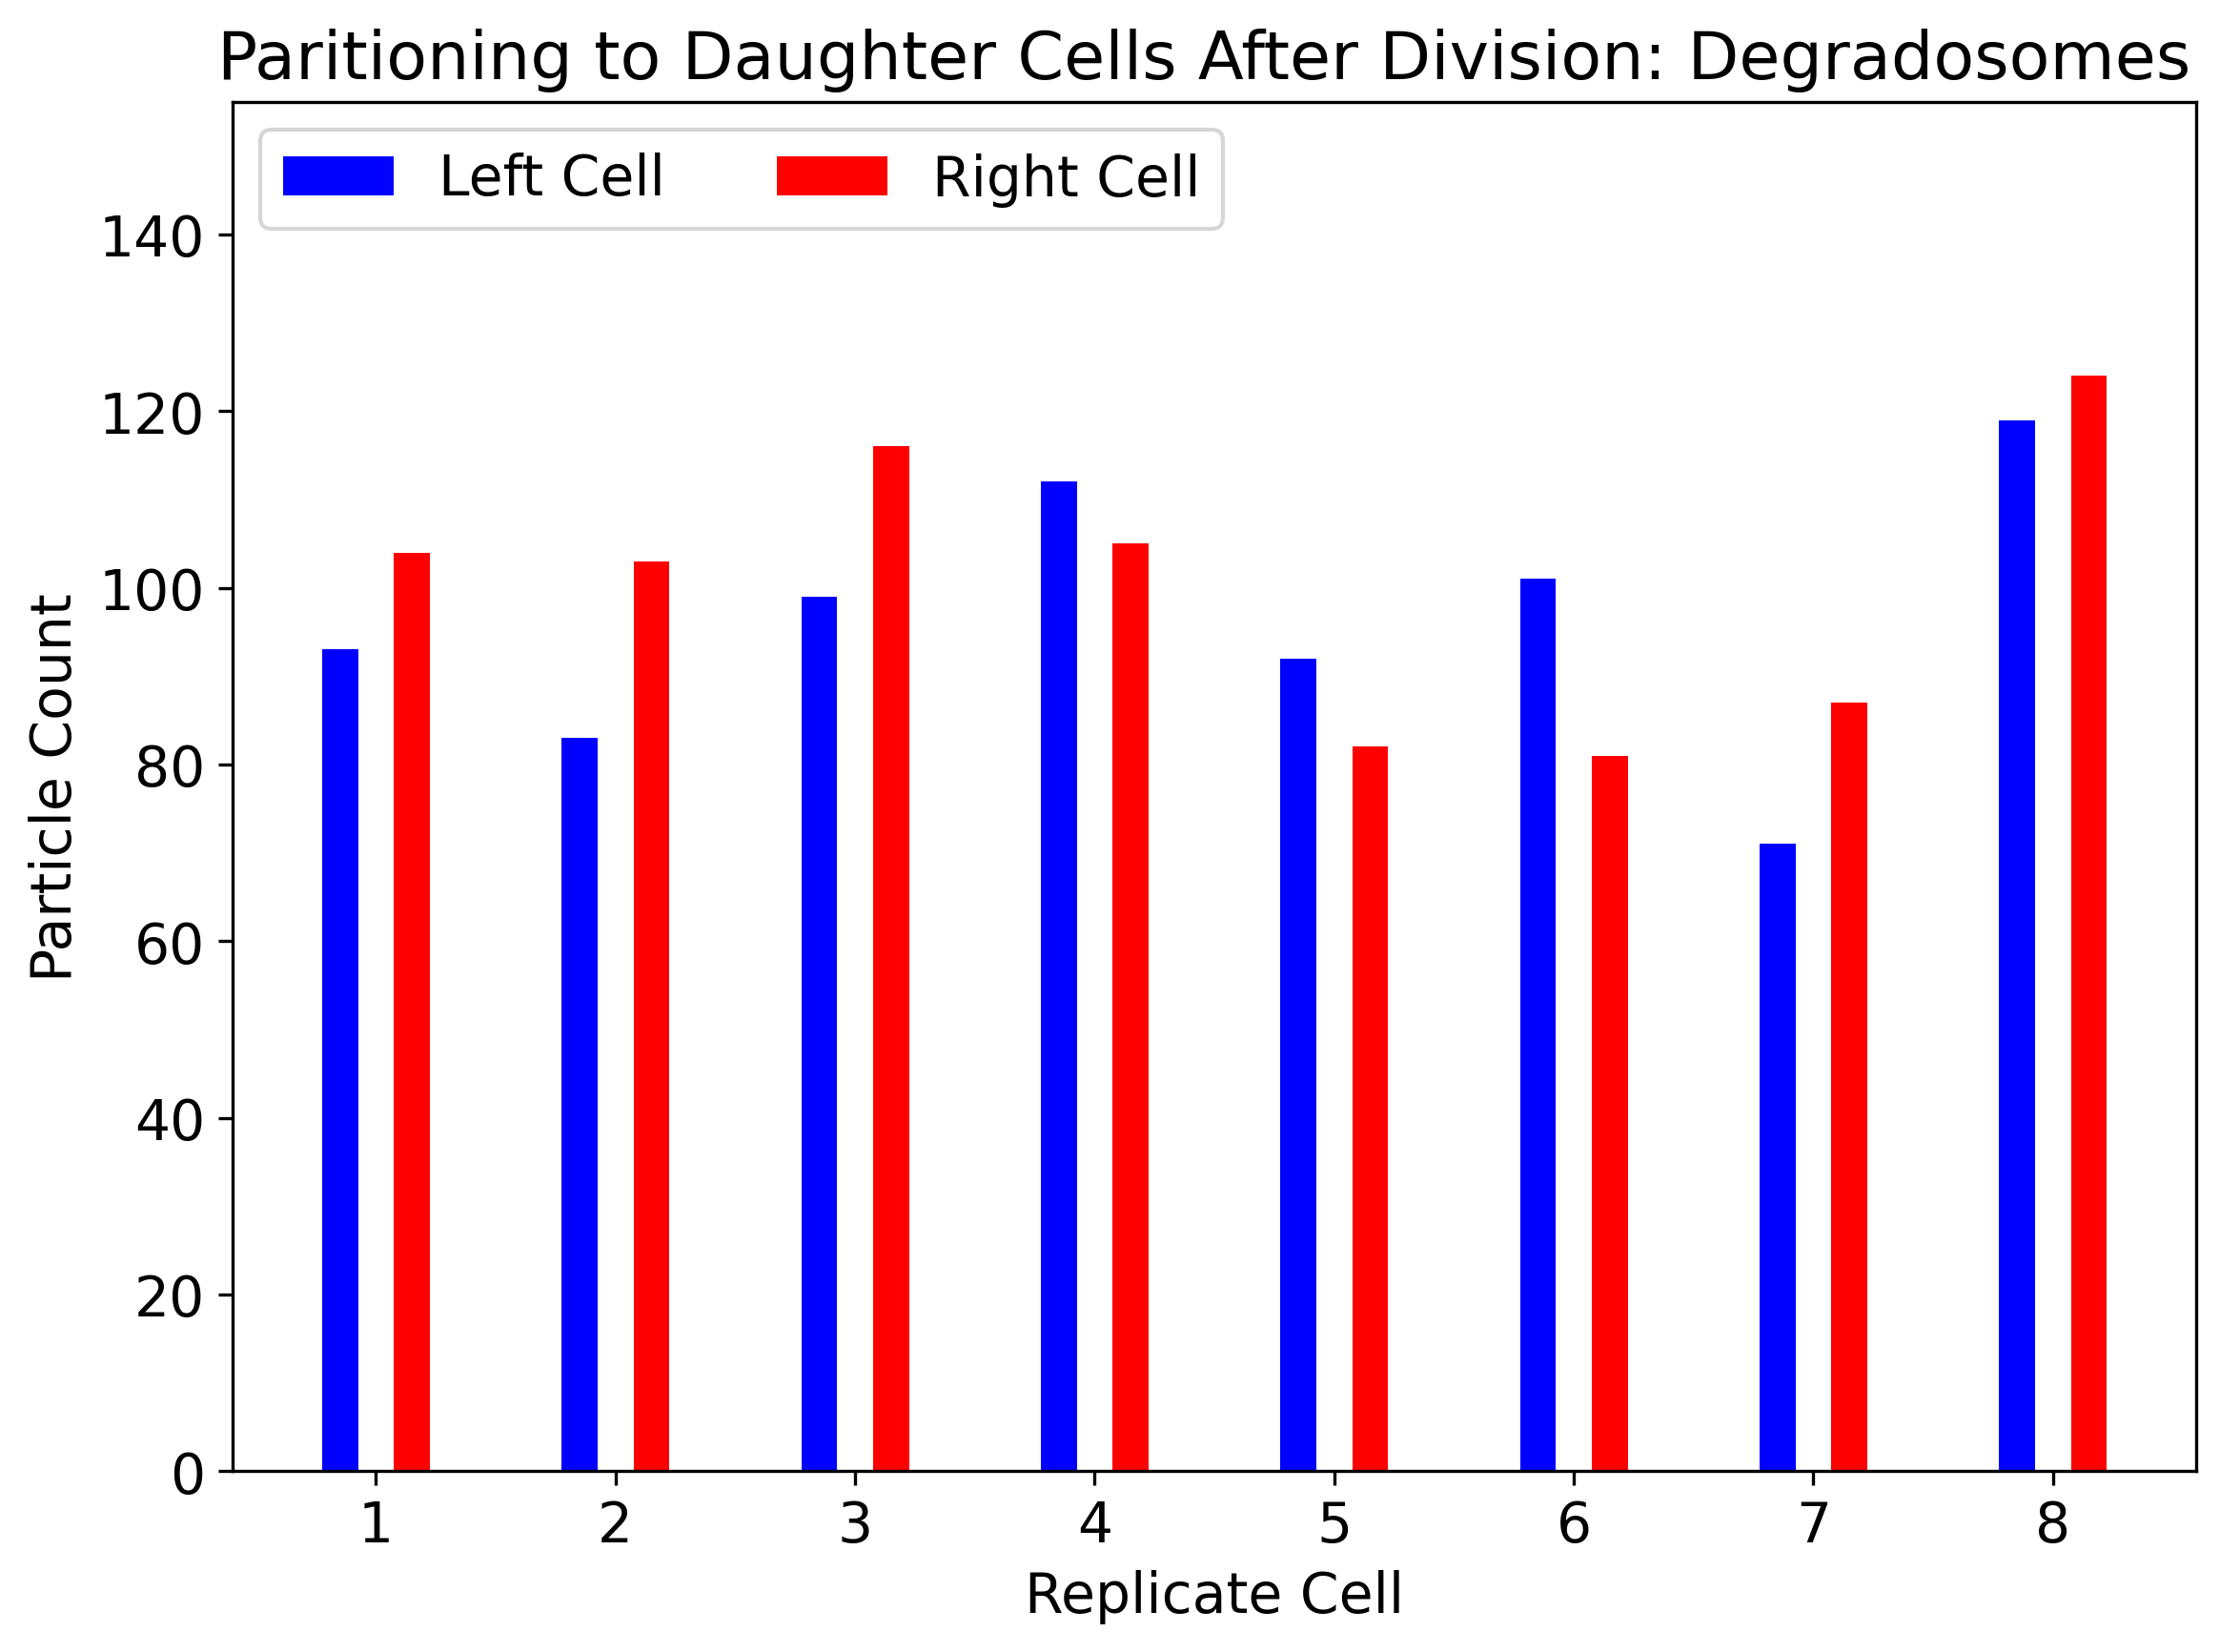

In [14]:
specID = ['Degradosome']

for pID in sN:
    if pID.startswith('D_'):
        specID.append(pID)

specCoords = getcoordsMult(specID)

dist = getDividedDist(specCoords)
plotDivDist(dist, 'Degradosomes')

partition = getPartitionedParticles(specCoords)
plotPartitioning(partition, 'Degradosomes')

/tmp/ipykernel_2060447/592334880.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


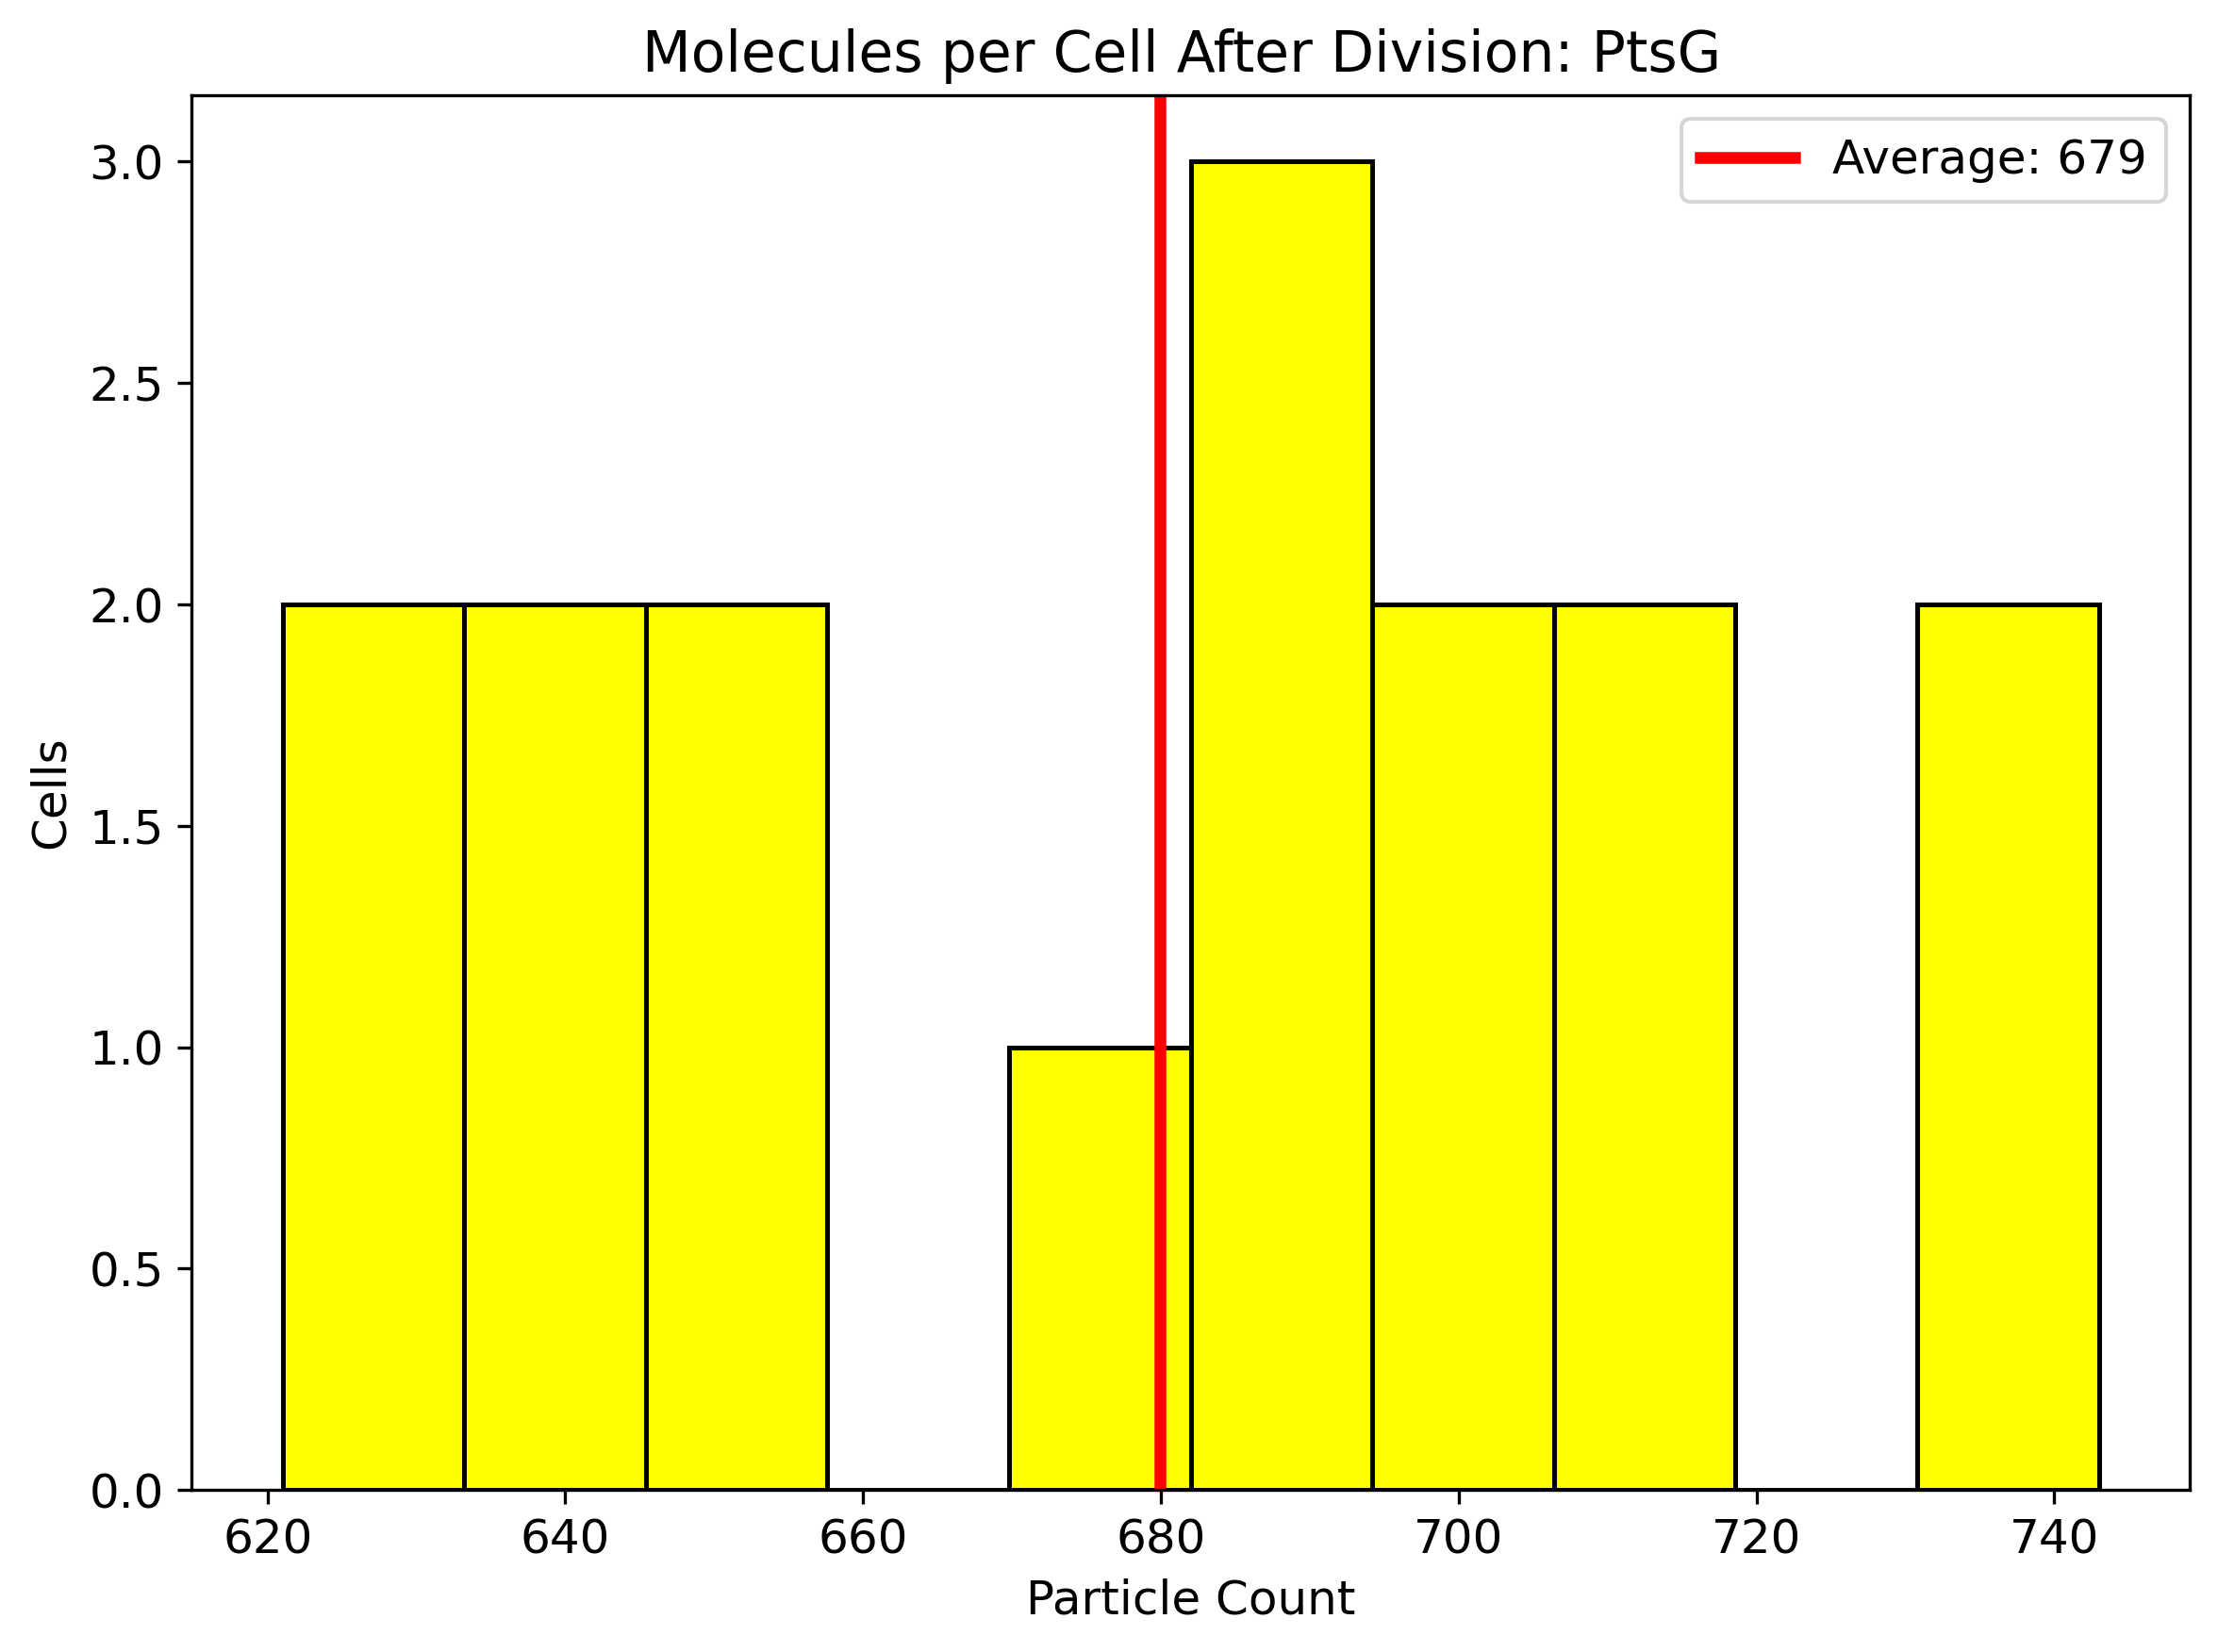

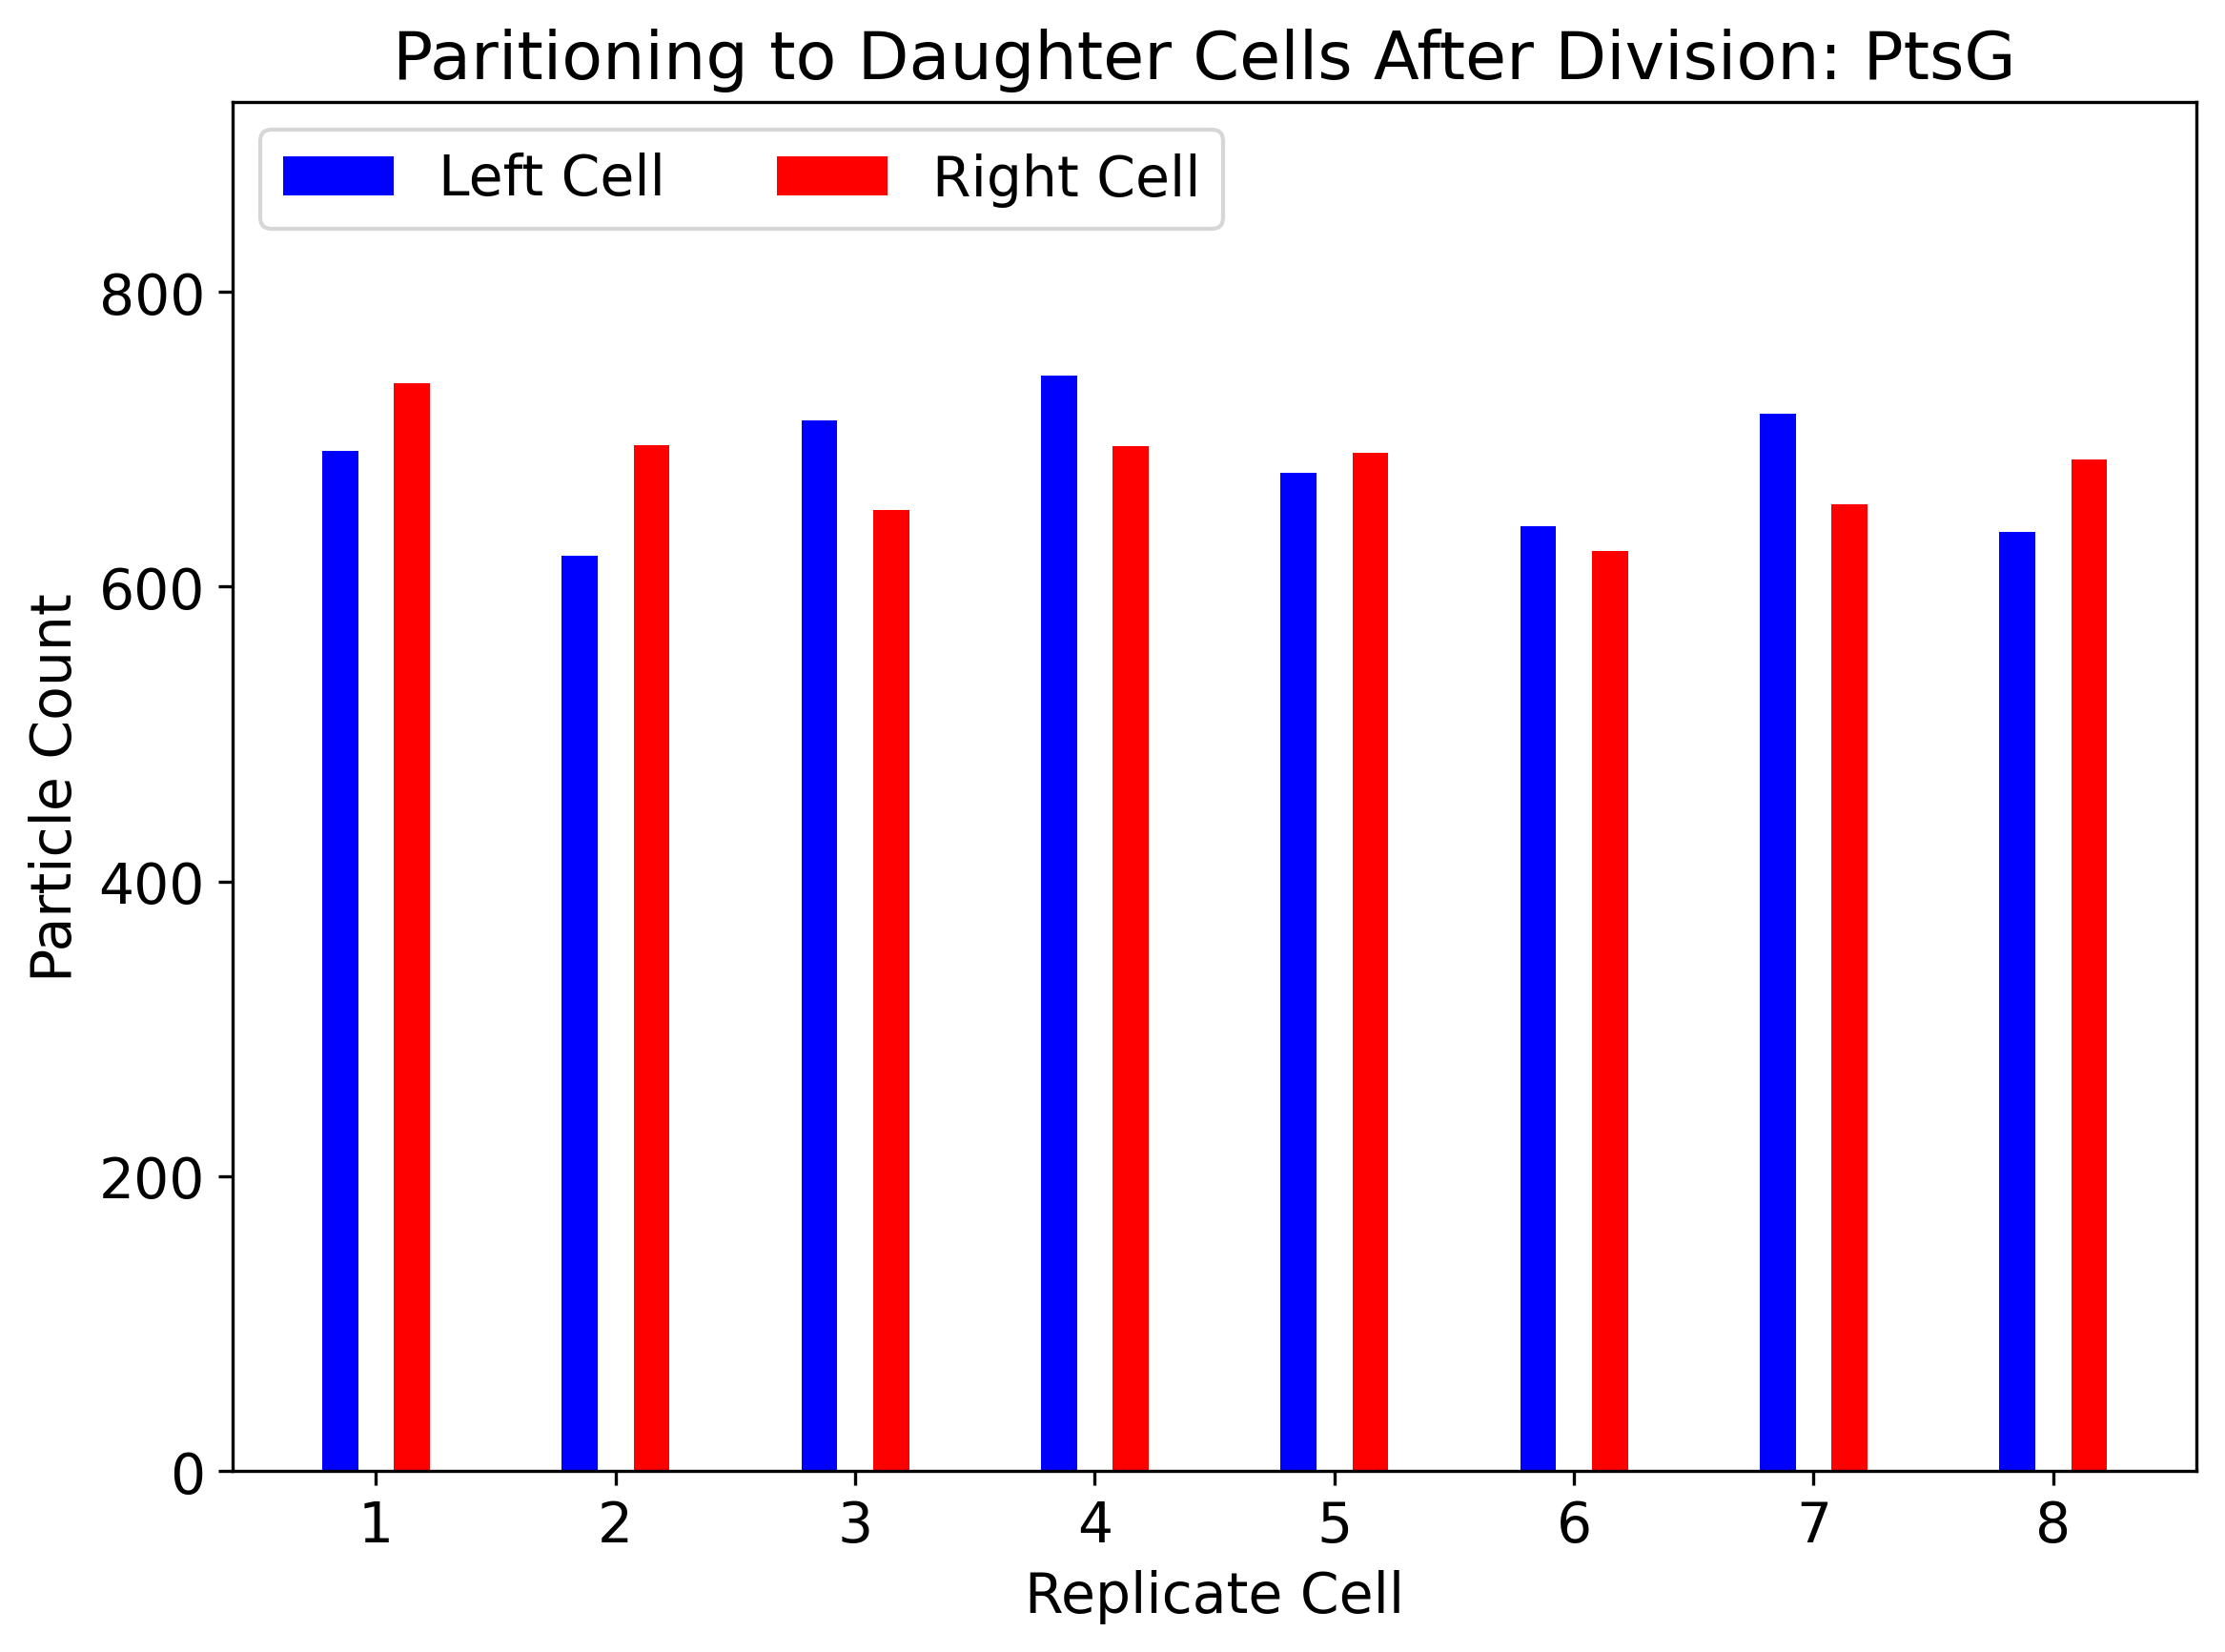

In [15]:
specID = 'P_0779'

specCoords = getcoords(specID)

dist = getDividedDist(specCoords)
plotDivDist(dist, 'PtsG')

partition = getPartitionedParticles(specCoords)
plotPartitioning(partition, 'PtsG')

/tmp/ipykernel_2060447/592334880.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


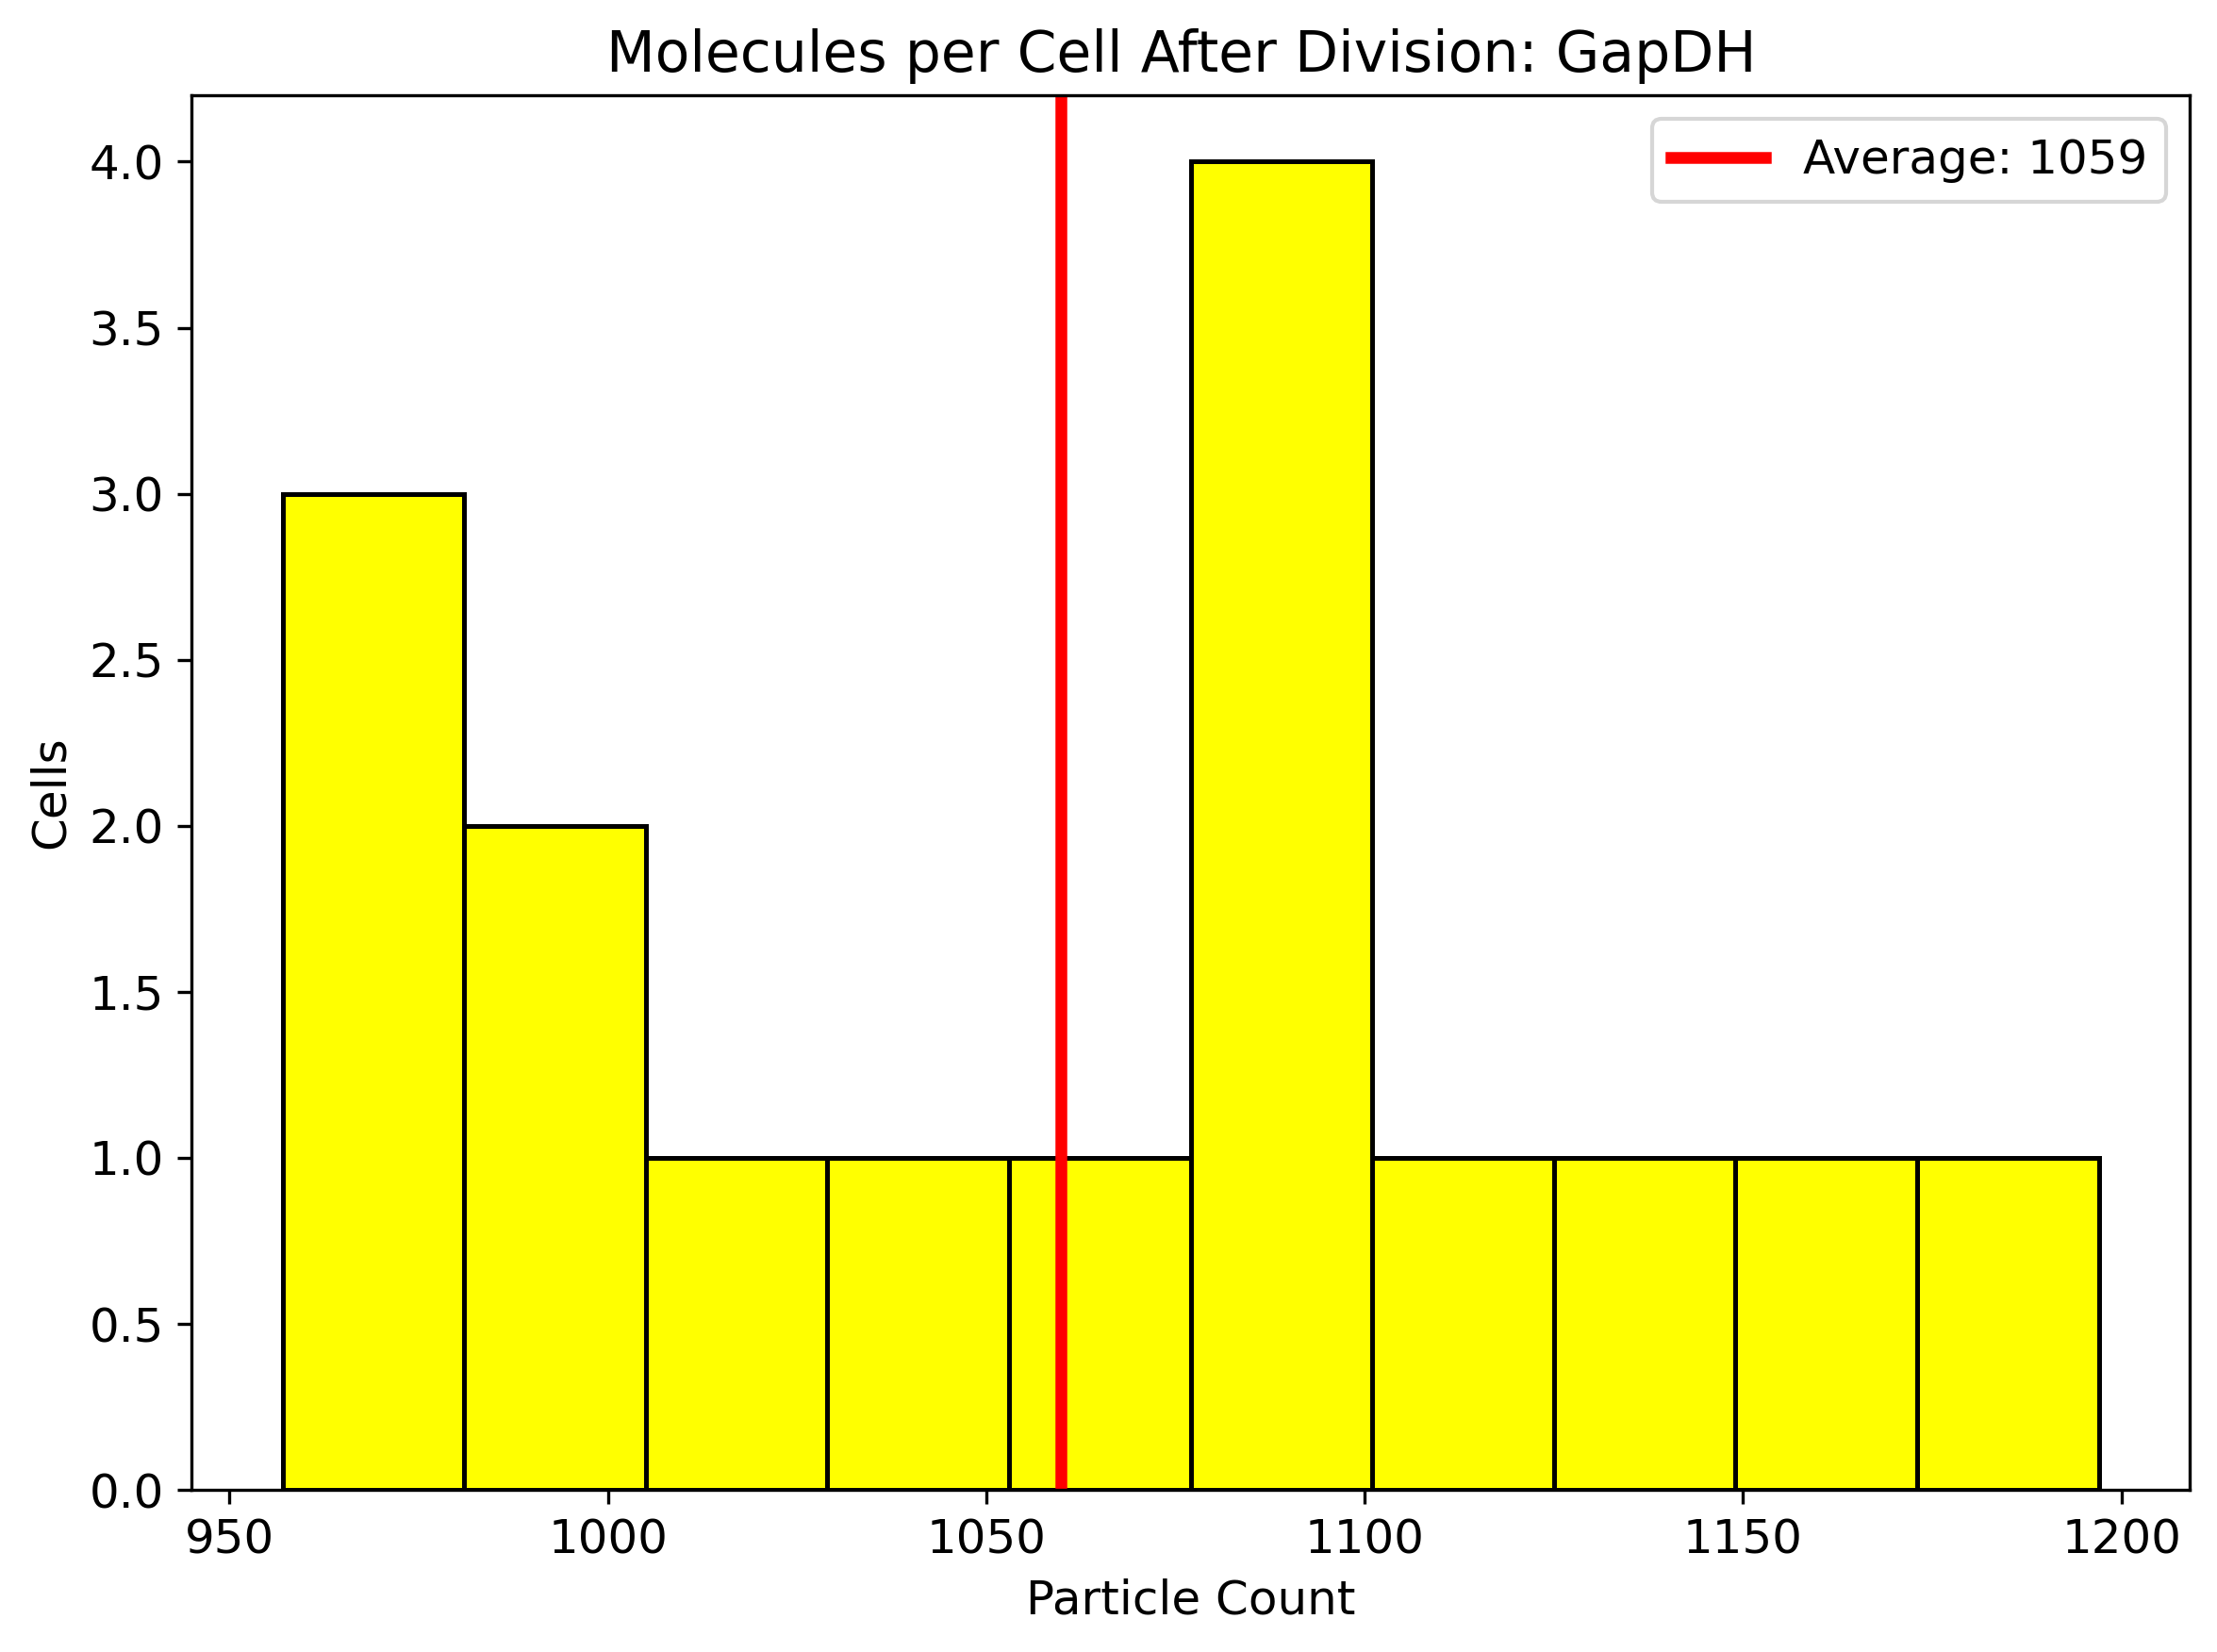

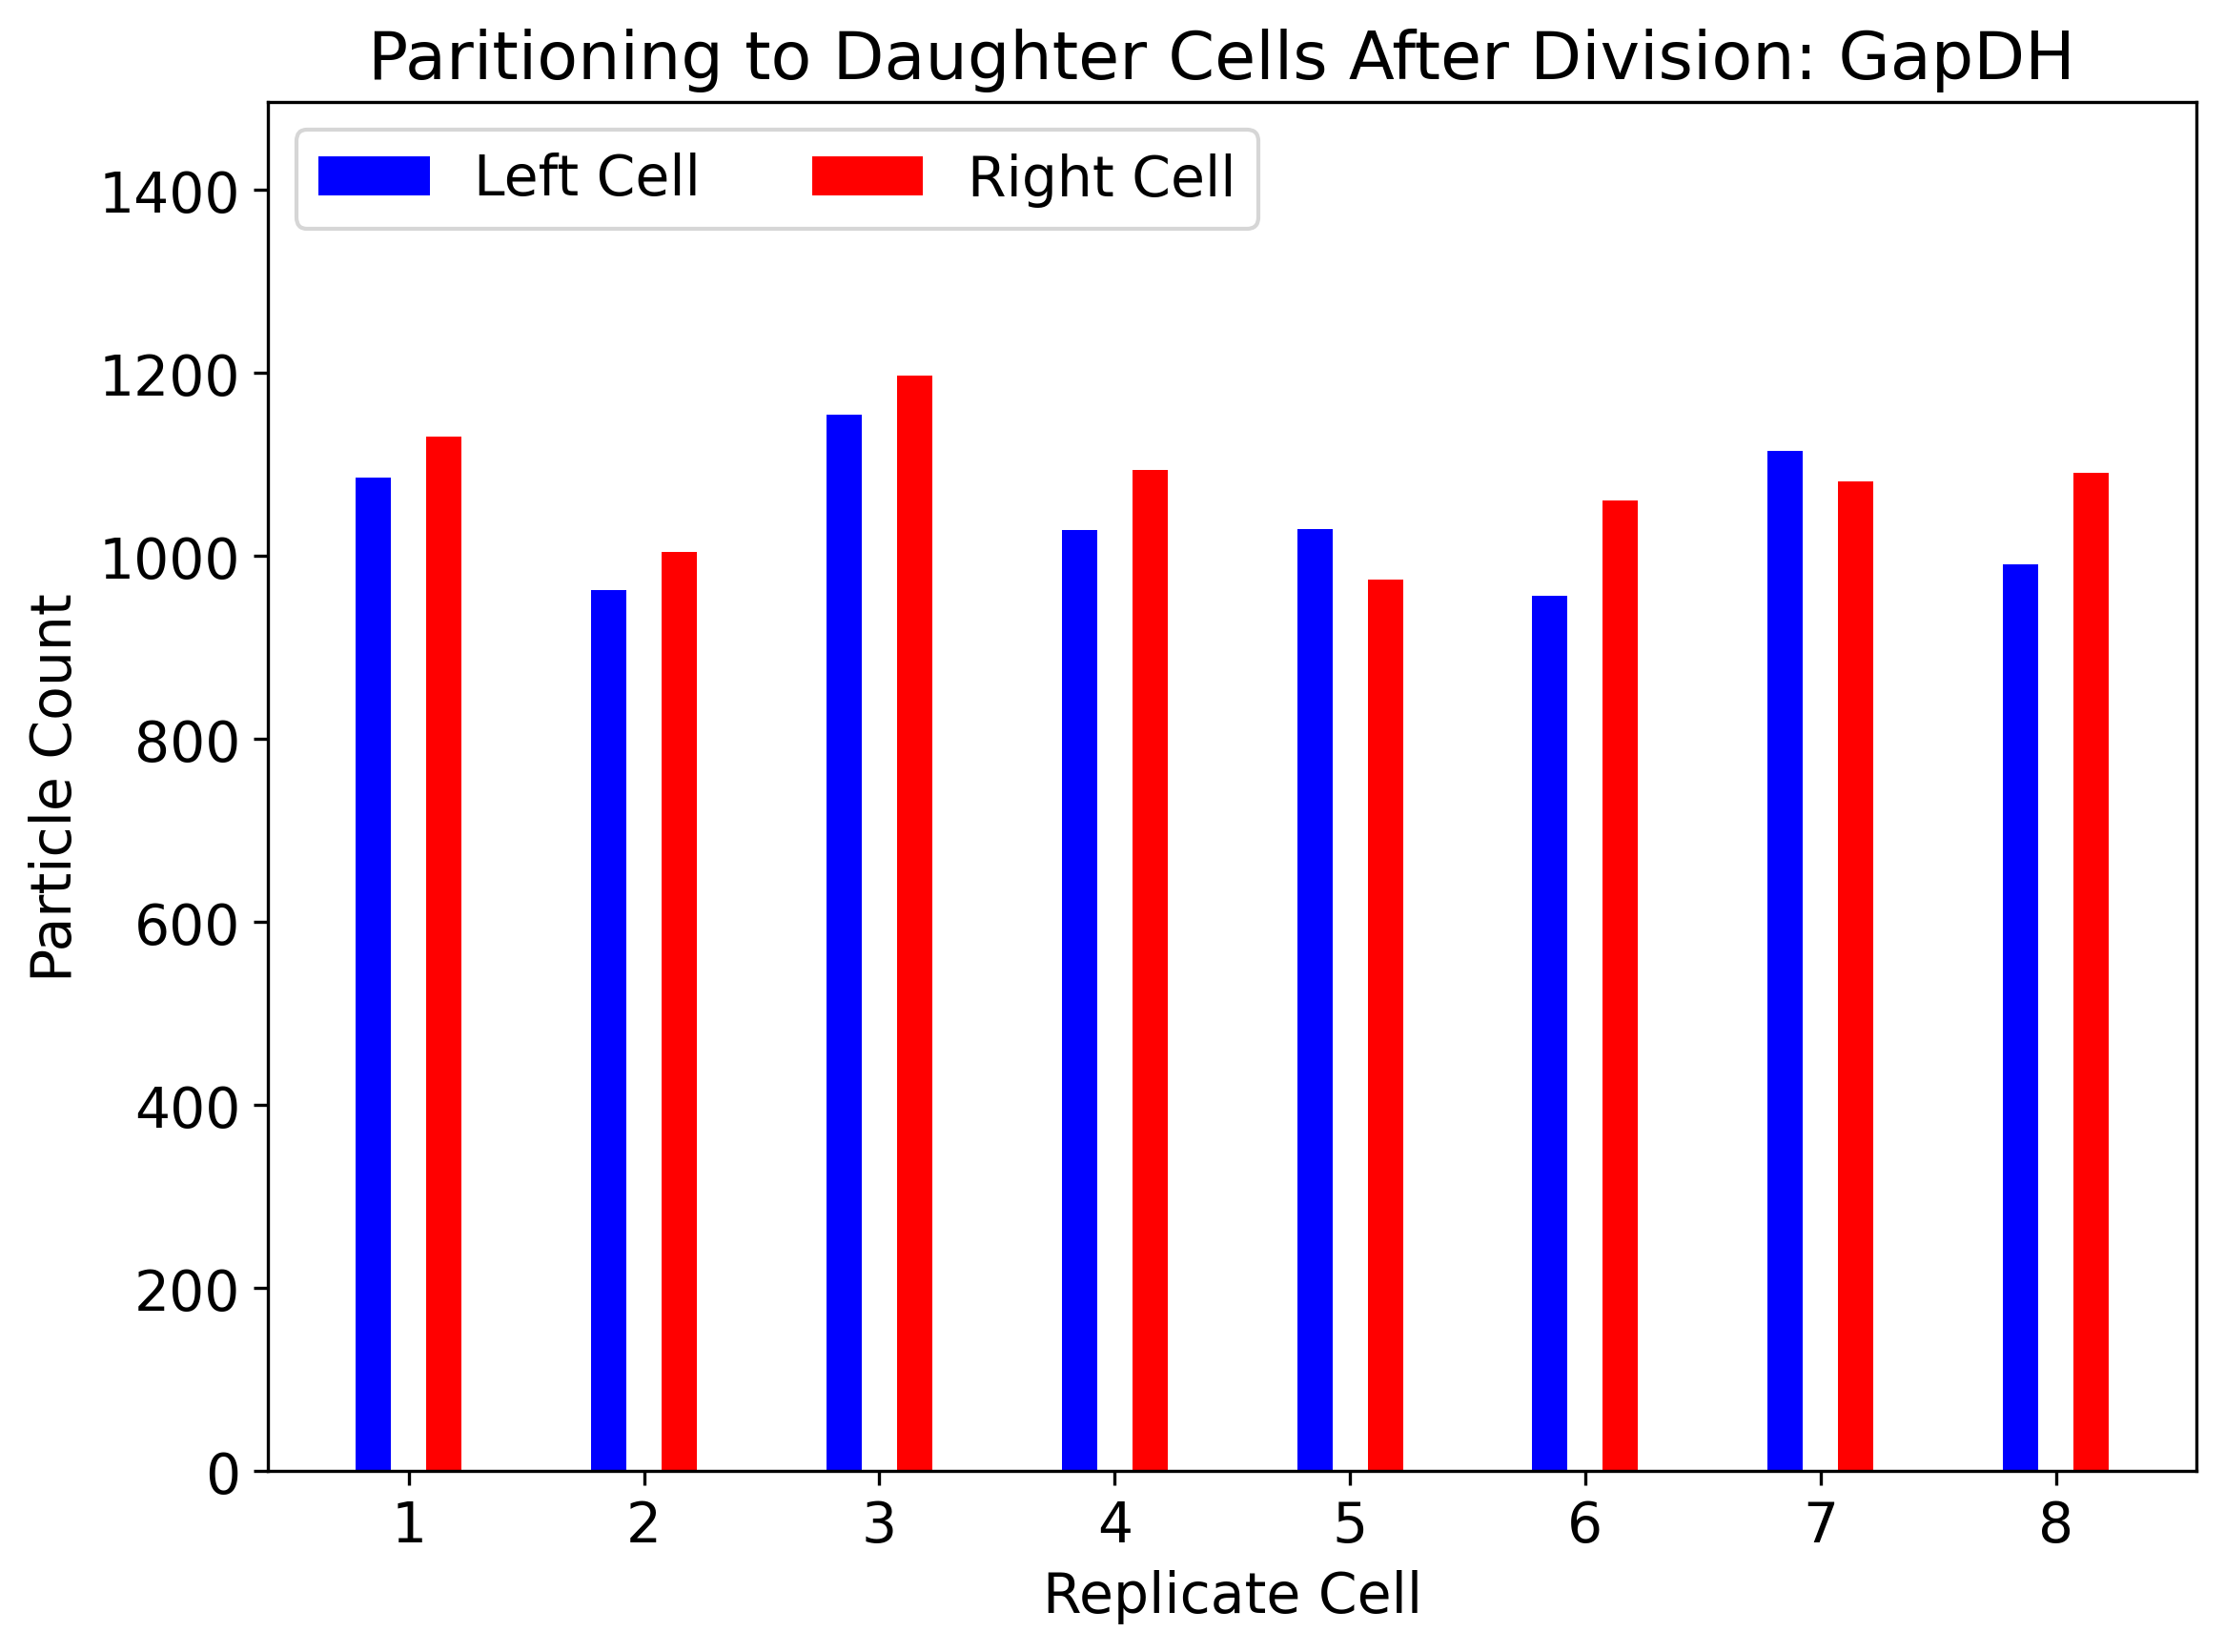

In [16]:
specID = 'P_0607'

specCoords = getcoords(specID)

dist = getDividedDist(specCoords)
plotDivDist(dist, 'GapDH')

partition = getPartitionedParticles(specCoords)
plotPartitioning(partition, 'GapDH')